In [1]:
''' 
@karlpy 
karl@elindicador.ai
Date: 2023-04-10
'''

' \n@karlpy \nDate: 2023-04-10\n'

In [2]:
import polars as pl
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

# Paso 1: Merge & BigQuery

- Primero hice merge de los [datos](https://drive.google.com/drive/folders/12EbE0PEEnCjUVjhzMDNa1W7M9tR4ZzwW?usp=share_link)
> awk -F ';' 'FNR==1 && NR!=1{next} {print}' *.csv | sed '/^$/d' > ../merged.csv
- Luego subí al CSV a BigQuery

La tabla de bigquery queda así
```bash
Campo Descripción Tipo de Dato
serialtarjeta: Serial de la Tarjeta que identifica al pasajero hash
idsam: Identificacion del bus de transporte público hash
fechahoraevento: timestamp del inicio del viaje timestamp
producto: Tipo de Producto string
montoevento: Monto del evento descontado de la tarjeta entero
consecutivoevento: Consecutivo del evento entero
identidad: Identidad entero
tipoevento: Tipo de Evento entero
latitude: Latitud geografica punto flotante
longitude: Longitud geografica punto flotante
idrutaestacion: Linea o ruta utilizada string
tipotransporte: tipo de transporte entero
```

## Reducción de dimensionalidad 
Intenté aplicar al algoritmo kmeans directamente a los datos en BigQuery, pero no terminó de procesar en más que 24h. Por lo cual hice una reducción de dimensionalidad con este query:

```sql
SELECT 
  serialtarjeta AS serialtarjeta,
  COUNT(*) AS count,
  AVG(CAST(montoevento AS NUMERIC)) AS avg_montoevento,
  STDDEV(CAST(montoevento AS NUMERIC)) AS stddev_montoevento,
  APPROX_QUANTILES(CAST(montoevento AS NUMERIC), 100)[OFFSET(50)] AS median_montoevento,
  AVG(CAST(consecutivoevento AS NUMERIC)) AS avg_consecutivoevento,
  STDDEV(CAST(consecutivoevento AS NUMERIC)) AS stddev_consecutivoevento,
  APPROX_QUANTILES(CAST(consecutivoevento AS NUMERIC), 100)[OFFSET(50)] AS median_consecutivoevento,
  AVG(CAST(identidad AS NUMERIC)) AS avg_identidad,
  STDDEV(CAST(identidad AS NUMERIC)) AS stddev_identidad,
  APPROX_QUANTILES(CAST(identidad AS NUMERIC), 100)[OFFSET(50)] AS median_identidad,
  AVG(CAST(tipoevento AS NUMERIC)) AS avg_tipoevento,
  STDDEV(CAST(tipoevento AS NUMERIC)) AS stddev_tipoevento,
  APPROX_QUANTILES(CAST(tipoevento AS NUMERIC), 100)[OFFSET(50)] AS median_tipoevento,
  AVG(latitude) AS avg_latitude,
  STDDEV(latitude) AS stddev_latitude,
  APPROX_QUANTILES(latitude, 100)[OFFSET(50)] AS median_latitude,
  AVG(longitude) AS avg_longitude,
  STDDEV(longitude) AS stddev_longitude,
  APPROX_QUANTILES(longitude, 100)[OFFSET(50)] AS median_longitude,
  AVG(CAST(tipotransporte AS NUMERIC)) AS avg_tipotransporte,
  STDDEV(CAST(tipotransporte AS NUMERIC)) AS stddev_tipotransporte,
  APPROX_QUANTILES(CAST(tipotransporte AS NUMERIC), 100)[OFFSET(50)] AS median_tipotransporte
FROM 
  `billetaje_electronico.billetaje_electronico`
GROUP BY 
  serialtarjeta
```


In [21]:
# leemos al CSV resultante del query de SQL
# link: https://drive.google.com/file/d/1UHAqyH5znO9JSOCn72Wgf8j7iIYWN9i8/view?usp=share_link

df = pd.read_csv('kmeans_data.csv')
# sort df by count and limit to the top 100000 for computational reasons. Drop NA values
df = df.sort_values(by=['count'], ascending=False).head(100000).dropna()
df

serialtarjeta  count  avg_montoevento  \
1417255  18f6e00ec04d8e05438254c3b1e8502b  22308      2279.056841   
1088854  bc069bee563eaca48c54a33f788b0f27  18562      2275.713824   
750579   9ab72b0115d5793f64285348af916464  16054      2275.364395   
1468947  0a0d03a58ca2cee8d5de631884cf6089  15285      2264.834805   
1033967  0e13796ff34ba4016a16cff9dd069430  14776      2275.250406   
...                                   ...    ...              ...   
271977   1736158e74dd5289d76efdeee4f22d08    462      2766.450216   
1205038  a101cd97421a233445c6956cb7abefa4    462      2334.848485   
580087   2179030098bf3e1ce0baab7a941d0fea    462      3032.900433   
975569   62d68627b98c253858eb6acb9afd0038    462      2902.380952   
933431   9656f3bc40a8fda23b77737fa84dda70    462      2923.160173   

         stddev_montoevento  median_montoevento  avg_consecutivoevento  \
1417255          179.384861                2300           12222.790075   
1088854          189.807037                2300           11688.451083   
750579           201.379194                2300           12003.938395   
1468947          231.780302                2300           10663.982466   
1033967          192.076387                2300           11270.323295   
...                     ...                 ...                    ...   
271977           696.582887                2800             930.906926   
1205038          873.506087                2300             741.389610   
580087           674.547608                3400             383.662338   
975569           602.322657                3400             468.365801   
933431           589.279103                3400             403.476190   

         stddev_consecutivoevento  median_consecutivoevento  avg_identidad  \
1417255               7060.140906                     12135       2.999955   
1088854               5713.184829                     11756       3.000000   
750579                4982.887146                     12145       2.999751   
1468947               4781.562746                     10747       2.999542   
1033967               4535.118314                     11293       3.000000   
...                           ...                       ...            ...   
271977                 179.226544                       942       2.956710   
1205038                205.209178                       740       2.829004   
580087                 177.877601                       381       2.898268   
975569                 166.623110                       470       2.779221   
933431                 147.356690                       406       2.867965   

         stddev_identidad  ...  median_tipoevento  avg_latitude  \
1417255          0.006695  ...                  4    -25.378768   
1088854          0.000000  ...                  4    -25.365048   
750579           0.015783  ...                  4    -24.723337   
1468947          0.021396  ...                  4    -25.360540   
1033967          0.000000  ...                  4    -25.361621   
...                   ...  ...                ...           ...   
271977           0.203730  ...                  4    -24.830072   
1205038          0.376913  ...                  4    -25.217485   
580087           0.302623  ...                  4    -25.136464   
975569           0.415222  ...                  4    -25.233301   
933431           0.338895  ...                  4    -24.488093   

         stddev_latitude  median_latitude  avg_longitude  stddev_longitude  \
1417255         0.240623        -25.37869     -57.367979          0.543560   
1088854         0.697169        -25.39545     -57.335974          1.582373   
750579          4.037565        -25.39556     -55.891729          9.128396   
1468947         0.616163        -25.39546     -57.388053          1.400222   
1033967         0.590647        -25.35815     -57.447023          1.347417   
...                  ...              ...            ...               ...   
271977          3.5039

# Kmeans

In [15]:
df.columns

Index(['serialtarjeta', 'count', 'avg_montoevento', 'stddev_montoevento',
       'median_montoevento', 'avg_consecutivoevento',
       'stddev_consecutivoevento', 'median_consecutivoevento', 'avg_identidad',
       'stddev_identidad', 'median_identidad', 'avg_tipoevento',
       'stddev_tipoevento', 'median_tipoevento', 'avg_latitude',
       'stddev_latitude', 'median_latitude', 'avg_longitude',
       'stddev_longitude', 'median_longitude', 'avg_tipotransporte',
       'stddev_tipotransporte', 'median_tipotransporte'],
      dtype='object')

## Buscamos a las columnas ideales para el algoritmo Kmeans

Best columns for clustering: ['count', 'avg_consecutivoevento', 'stddev_consecutivoevento', 'median_consecutivoevento']


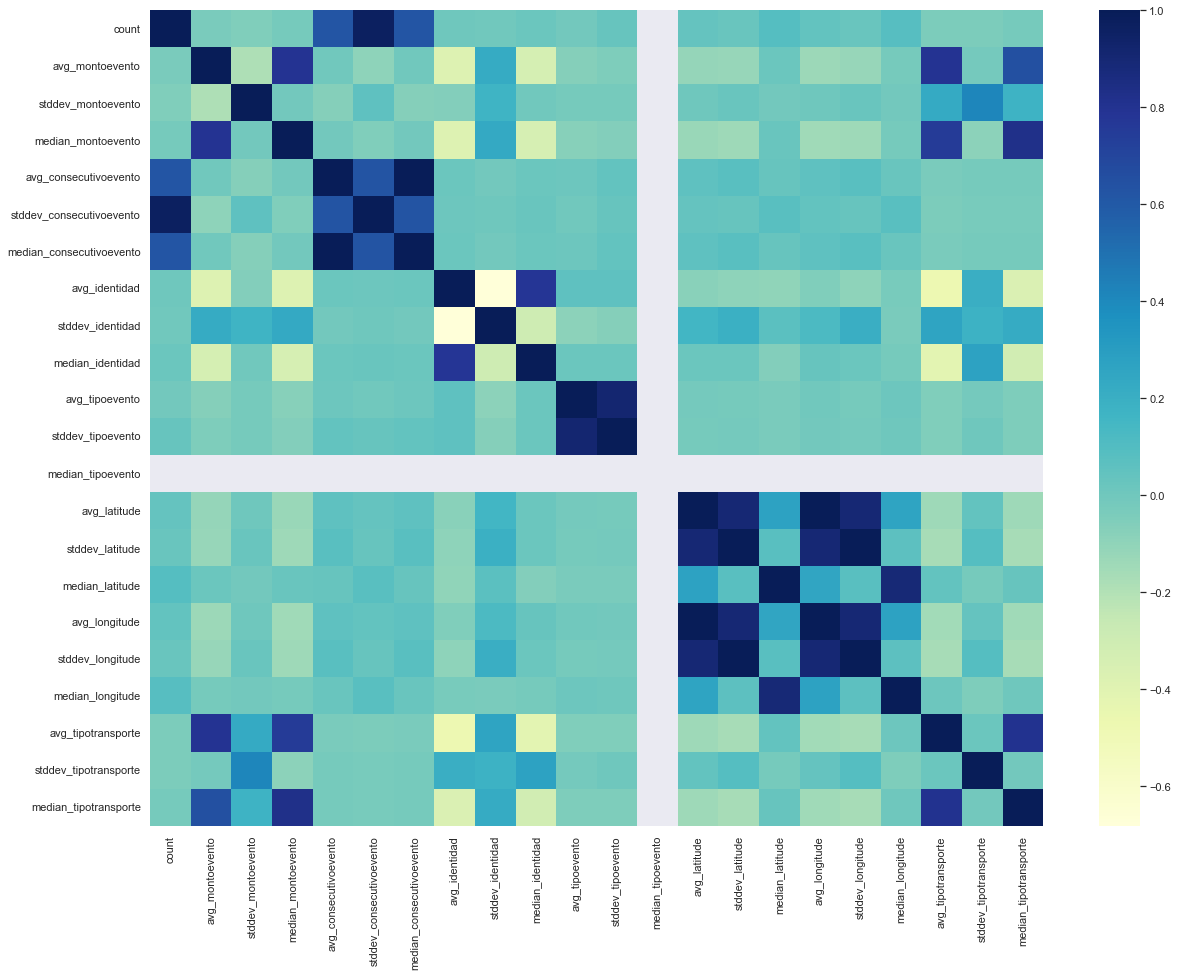

In [30]:
# Separate out the id column
id_col = df['serialtarjeta']
df_corr = df.drop('serialtarjeta', axis=1)

# Find the best columns for clustering using correlation
corr_matrix = df_corr.corr()
corr_with_id = corr_matrix.iloc[0]
best_cols = list(corr_with_id[corr_with_id.abs() > 0.1].index)
print('Best columns for clustering:', best_cols)

# plot the correlation matrix using a heatmap
sns.heatmap(corr_matrix, cmap="YlGnBu")

# display the plot
plt.show()

## Buscamos al numero óptimo de clusteres 

c:\ProgramData\mambaforge\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\ProgramData\mambaforge\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\ProgramData\mambaforge\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\ProgramData\mambaforge\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\ProgramData\mambaforge\lib\site-packages\kneed\kn

Optimum Clusters:  None


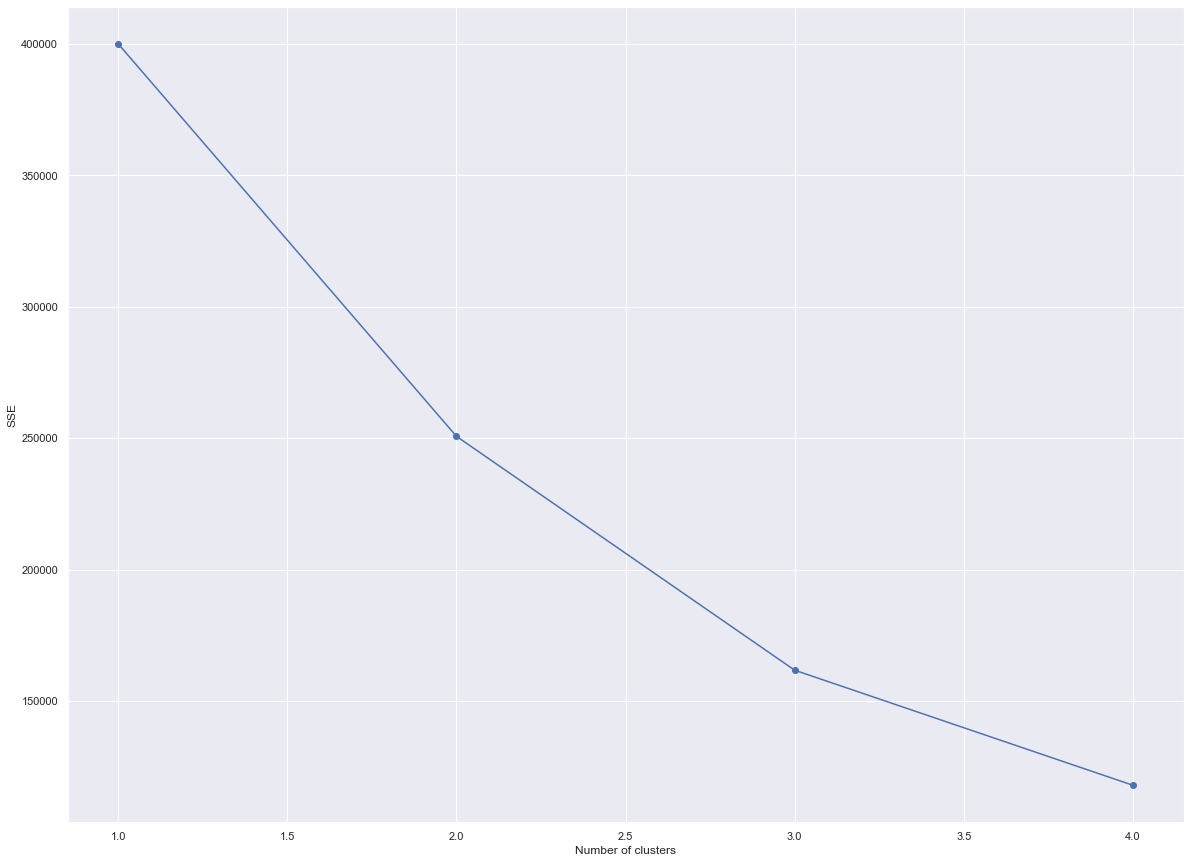

In [31]:
from kneed import KneeLocator

# Normalize the data
scaler = StandardScaler()
df_norm = scaler.fit_transform(df[best_cols])

# Determine the optimal number of clusters using the KneeLocator
distortions = []
n_columns = len(best_cols) + 1
for k in range(1, n_columns):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df_norm)
    distortions.append(kmeans.inertia_)
    
kl = KneeLocator(range(1, n_columns), distortions, curve="convex", direction="decreasing")
c = kl.elbow
print("Optimum Clusters: ", c)

# Plot the SSE against number of clusters
plt.plot(range(1, n_columns), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
if c is not None:
    plt.vlines(c, ymin=distortions[0], ymax=distortions[-1], colors='r', linestyles='dashed')
plt.show()


## Aplicamos al algoritmo de Kmeans

In [34]:
# Fit the KMeans model using the optimal number of clusters
kmeans = KMeans(n_clusters=n_columns)
kmeans.fit(df_norm)

# Add the cluster labels and id column back to the dataframe
df['cluster'] = kmeans.labels_
df['serialtarjeta'] = id_col

# Print the cluster sizes
print(df['cluster'].value_counts())

c:\ProgramData\mambaforge\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


1    43340
4    34631
2    18171
0     3825
3       33
Name: cluster, dtype: int64


## Hacemos una pre-visualización

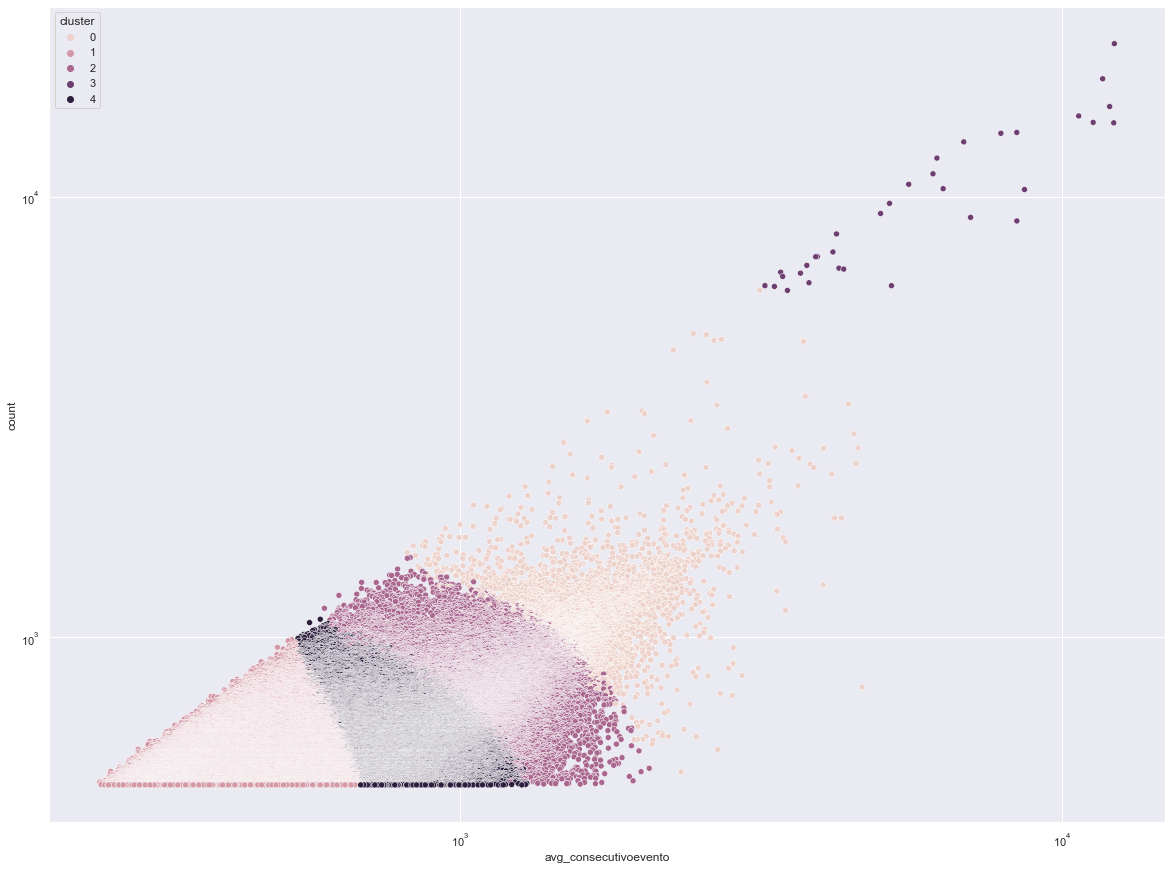

In [35]:
import seaborn as sns

# Create a 20 by 15 scatterplot of the data colored by cluster
sns.set(rc={'figure.figsize':(20,15)})
sns.scatterplot(data=df, x='avg_consecutivoevento', y='count', hue='cluster')
# Set axis to log scale
plt.yscale('log')
plt.xscale('log')
plt.show()

In [36]:
# Data is too big for TSNE

# from sklearn.manifold import TSNE

# # Fit t-SNE to the normalized data
# tsne = TSNE(learning_rate=200, random_state=42)
# df_tsne = tsne.fit_transform(df_norm)

# # Add the t-SNE coordinates to the dataframe
# df['tsne_x'] = df_tsne[:,0]
# df['tsne_y'] = df_tsne[:,1]

# # Create a scatterplot of the data colored by cluster
# sns.scatterplot(data=df, x='tsne_x', y='tsne_y', hue='cluster')


## Visualizamos usando UMAP (una alternativa mas rápida a TSNE)

<AxesSubplot:xlabel='umap_x', ylabel='umap_y'>

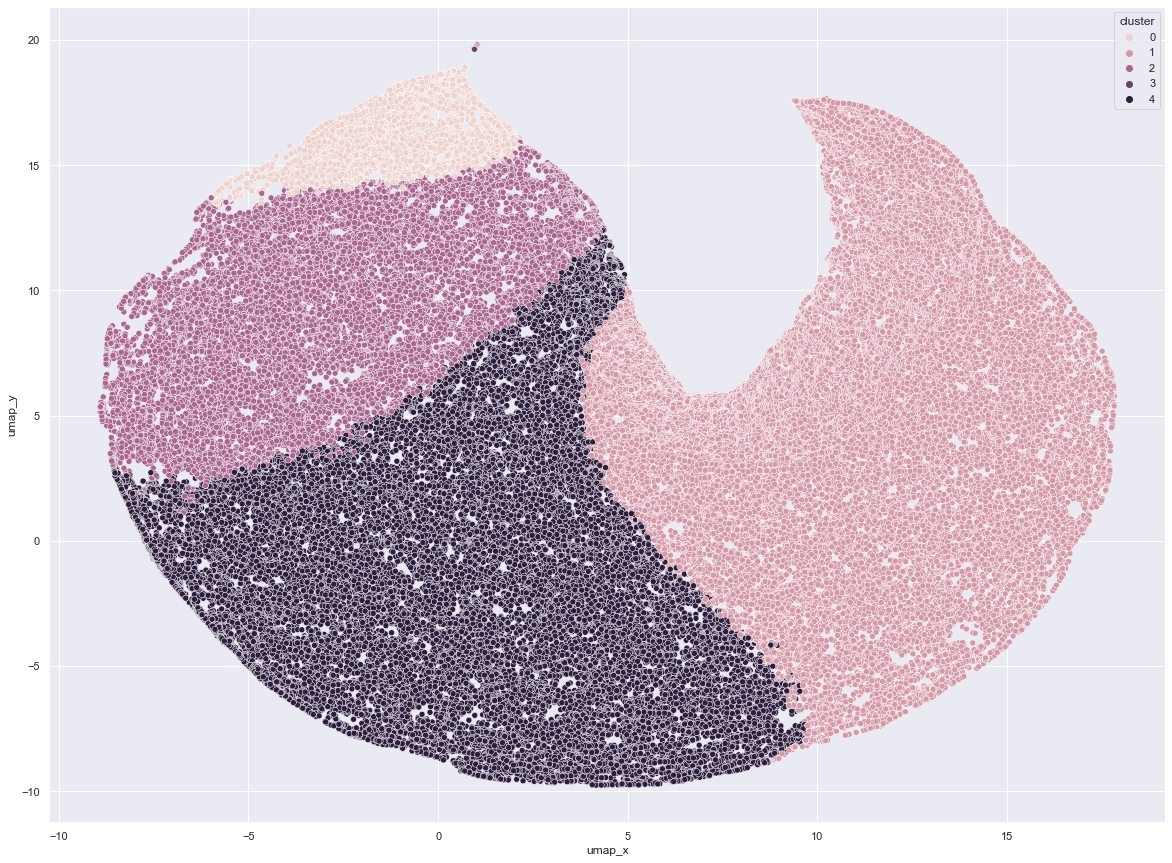

In [37]:
import umap

# Fit UMAP to the normalized data
umap_model = umap.UMAP(metric='euclidean', random_state=42)
umap_embeddings = umap_model.fit_transform(df_norm)

# Add the UMAP coordinates to the dataframe
df['umap_x'] = umap_embeddings[:,0]
df['umap_y'] = umap_embeddings[:,1]

# Create a scatterplot of the data colored by cluster
sns.scatterplot(data=df, x='umap_x', y='umap_y', hue='cluster')


In [39]:
import plotly.express as px

# Create a scatterplot of the data colored by cluster
fig = px.scatter(df, x='umap_x', y='umap_y', color='cluster')

# Set the size of the figure
fig.update_layout(width=1000, height=750)

# Show the plot
fig.show()
fig.write_html("kmeans_umap.html")
